In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

import sys
sys.path.append('/sdf/home/c/carsmith/flash_reconstruction/siren-lartpc')
sys.path.append('..')

In [5]:
import time
from math import ceil
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.tensorboard
import numpy as np
import yaml
from make_waveform import BatchedLightSimulation, mod0_sampler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, trange

device = torch.device('cuda:0')

sim = BatchedLightSimulation(cfg="templates/waveform_sim.yaml").to(device) # gives input / "true" 2D timing distribution

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]


In [6]:
'''
TODO
- Configuration for simulator ✅
- be able to use 1.0 singlet ✅
- check that waveform starts exactly at 0 (+ offset) ✅
- TPB wavelength shifter: 
    - absorption spectrum
    - re-emission spectrum
    - re-emission time distribution / delay ✅
'''

'\nTODO\n- Configuration for simulator ✅\n- be able to use 1.0 singlet ✅\n- check that waveform starts exactly at 0 (+ offset) ✅\n- TPB wavelength shifter: \n    - absorption spectrum\n    - re-emission spectrum\n    - re-emission time distribution / delay ✅\n'

### Reconfiguring simulation properties
```
NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
NOMINAL_TAU_S: 0.001                       # us
NOMINAL_TAU_T: 1.530                       # us
NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
```

In [7]:
# singlet_fraction, tau_s, tau_t, light_oscillation_period, light_gain, light_response_time
params = dict()

params['singlet_fraction'] = 1
params['light_oscillation_period'] = 0.11
params['light_response_time'] = 0.055
params['tau_s'] = 0.001
params['tau_t'] = 1.530
params['light_gain'] = -45.0

sim.reconfigure(params)
print(sim.singlet_fraction)

1


### First, switching plotting to 1D representations

Waveform shape: torch.Size([128, 16000])


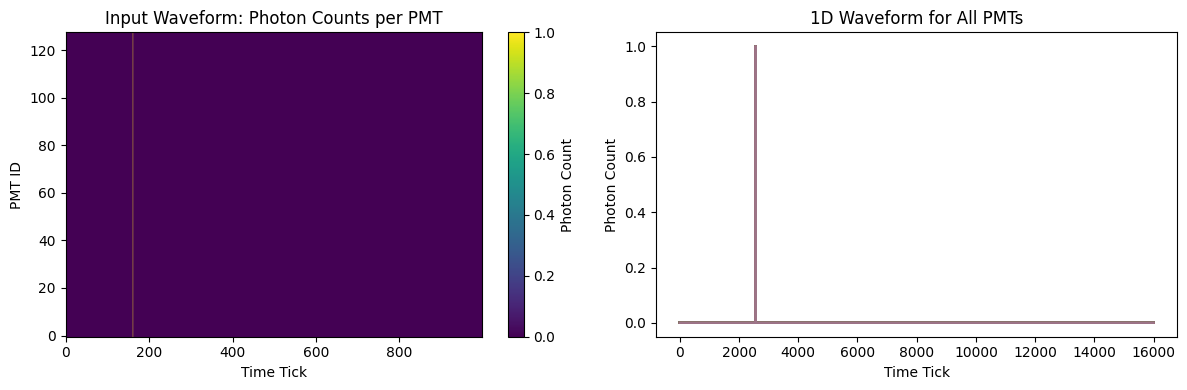

In [8]:
# pmt_ids = torch.randint(0, 128, (10000,))
# arrival_times = torch.randint(0, 1000, (10000,))

# One photon per pmt
pmt_ids = torch.arange(128)
arrival_times = torch.zeros(128, dtype=torch.int64)
wf = sim.gen_waveform(pmt_ids=pmt_ids, arrival_times=arrival_times)
downsampled_wf = sim.downsample_waveform(wf.unsqueeze(0))

print(f"Waveform shape: {wf.shape}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Left plot: 2D waveform image from downsampled_wf
im = ax1.imshow(downsampled_wf.squeeze(0), aspect='auto', origin='lower')
ax1.set_xlabel("Time Tick")
ax1.set_ylabel("PMT ID")
ax1.set_title("Input Waveform: Photon Counts per PMT")
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Photon Count")

# Right plot: 1D waveform lines from wf
n_pmts, n_ticks = wf.shape
ticks = np.arange(n_ticks)

for i in range(n_pmts):
    ax2.plot(ticks, wf[i], alpha=0.5)
ax2.set_xlabel("Time Tick")
ax2.set_ylabel("Photon Count")
ax2.set_title("1D Waveform for All PMTs")

plt.tight_layout()
plt.show()

### Next, Inspect Output with Stochastic Scintillation

Output shape: (128, 1000)


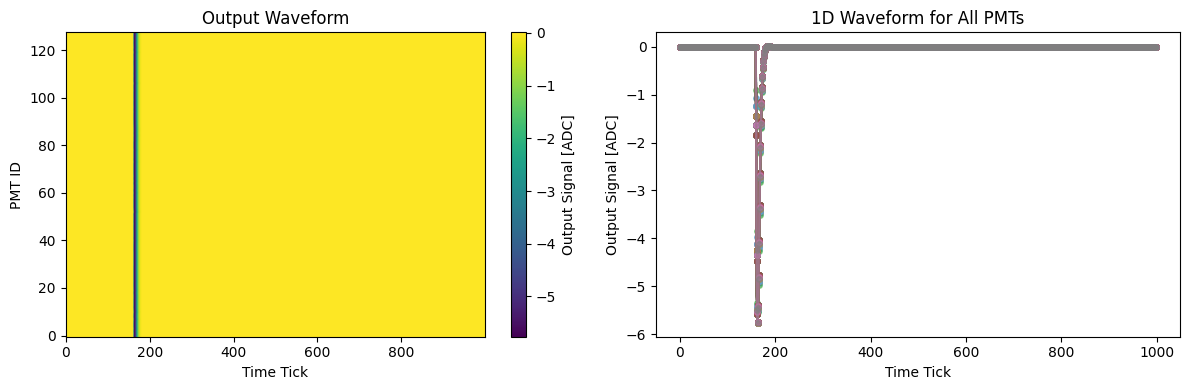

In [9]:
output, info, scint_delays = sim(wf.to(device))
output = output.detach().cpu().numpy()
print(f"Output shape: {output.shape}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 2D timing histogram
im = ax1.imshow(output, aspect='auto', origin='lower')
ax1.set_xlabel("Time Tick")
ax1.set_ylabel("PMT ID")
ax1.set_title("Output Waveform")

cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Output Signal [ADC]")

# 1D line plot
ticks = np.arange(output.shape[1])
for i in range(n_pmts):
    ax2.plot(ticks, output[i], marker = 'o', markersize=4, alpha=0.5, label=i)
    # ax2.scatter(ticks, output[i], marker = 'o', label=i)
    # print(i, np.argmin(output[i]))
# ax2.plot(np.sum(output, axis=0), color='black')
ax2.set_xlabel("Time Tick")
ax2.set_ylabel("Output Signal [ADC]")
ax2.set_title("1D Waveform for All PMTs")
# plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Checking that waveform starts exactly at 0 (or some offset)
# for all channels, get first nonzero value
print(output.shape)
mask = output< -0.001
selected_values = output[mask]
masked_output = output.copy()  # avoid modifying original
masked_output[~(output < -0.001)] = 0

print("signal starts at index: ", np.argmax(masked_output != 0))
print("it should start at: ", 2560 / 16)

(128, 1000)
signal starts at index:  160
it should start at:  160.0


BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]
sirentv output shape: (128, 1000)
1
1
aligned waveform shapes: (986,), (986,)


Text(0.5, 1.0, '1D Waveform for PMT 40 with Scint. Sampling')

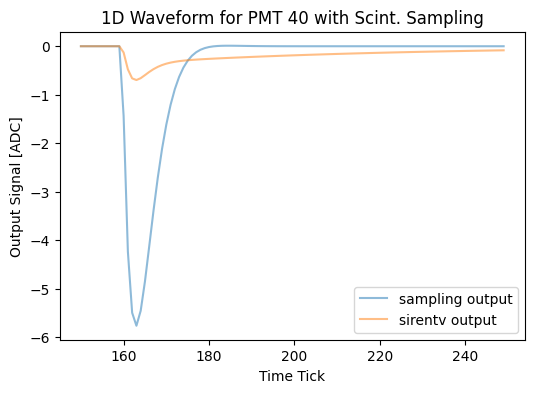

In [11]:
from sirentv.sirentv.waveform import BatchedLightSimulation

sim_sirentv = BatchedLightSimulation(cfg="../sirentv/templates/waveform_sim.yaml").to(device)
sirentv_output = sim_sirentv(wf.to(device))
sirentv_output = sirentv_output.detach().cpu().numpy()
print(f"sirentv output shape: {sirentv_output.shape}")

# strategy for aligning them
def align_waveforms(wf1: torch.Tensor, wf2: torch.Tensor, pad_start: int = 30, pad_end: int = 10):
    '''
    Lining them up, given 2 waveforms of shape (16000)
    - first, identify where waveform becomes nonzero
    - crop to start 30 ticks earlier
    - then, identify where waveform becomes zero again
    - crop to end 10 ticks later
    '''
    def crop_waveform(wf: torch.Tensor):
        nonzero_indices = (wf > 1e-8).nonzero()
        print(len(nonzero_indices))
        if len(nonzero_indices) == 0:
            return wf  # return as-is if entirely zero
        start_idx = max(nonzero_indices[0][0] - pad_start, 0)
        end_idx = min(nonzero_indices[0][-1] + pad_end + 1, wf.shape[0])
        return wf[start_idx:end_idx]

    cropped_wf1 = crop_waveform(wf1)
    cropped_wf2 = crop_waveform(wf2)

    # choose longest one
    # crop it to match shorter one by taking evenly off both sides
    len1 = cropped_wf1.shape[0]
    len2 = cropped_wf2.shape[0]

    if len1 > len2:
        diff = len1 - len2
        start = diff // 2
        end = start + len2
        cropped_wf1 = cropped_wf1[start:end]
    elif len2 > len1:
        diff = len2 - len1
        start = diff // 2
        end = start + len1
        cropped_wf2 = cropped_wf2[start:end]
    
    return cropped_wf1, cropped_wf2

# Pick one PMT waveform to inspect up close
aligned_wf1, aligned_wf2 = align_waveforms(output[40], sirentv_output[40])
print(f"aligned waveform shapes: {aligned_wf1.shape}, {aligned_wf2.shape}")
# ticks = np.arange(aligned_wf1.shape[0])
ticks = np.arange(150, 250)

plt.figure(figsize=(6, 4))
plt.plot(ticks, output[40][150:250], alpha=0.5, label='sampling output')
plt.plot(ticks, sirentv_output[40][150:250], alpha=0.5, label='sirentv output')
plt.xlabel("Time Tick")
plt.ylabel("Output Signal [ADC]")
plt.legend()
plt.title("1D Waveform for PMT 40 with Scint. Sampling")

### Adding new sampling modes to `gen_waveform`

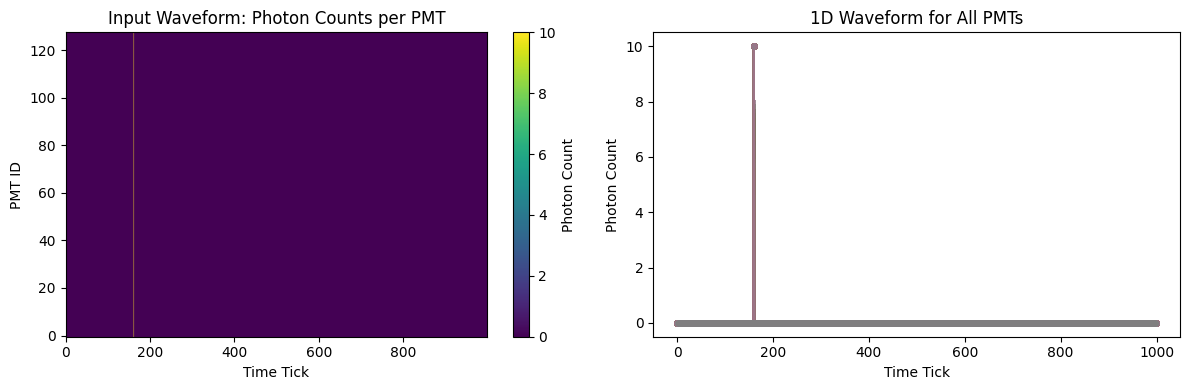

Output shape: (128, 1000)


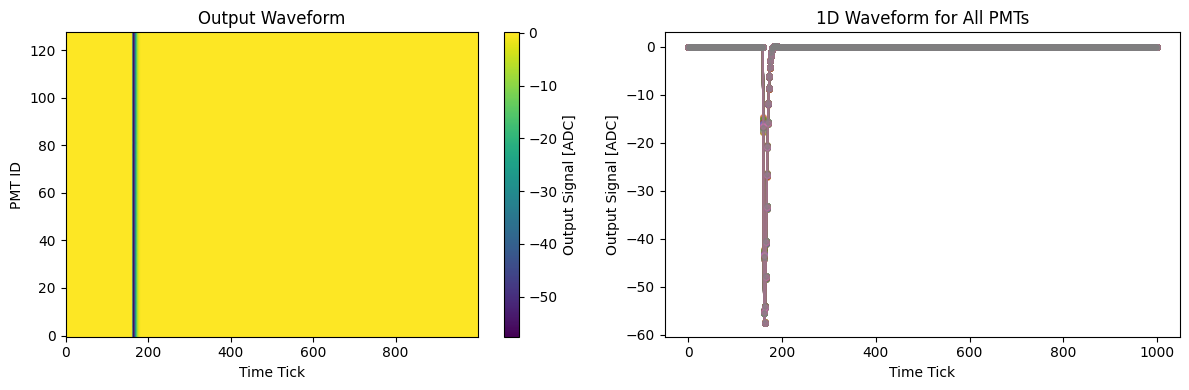

In [12]:
# def gen_waveform_gaussian(self, pmt_ids: torch.Tensor, nphotons: torch.Tensor, arrival_mean:float=0.0, std:float=1.0, n_pmts:int=129):

# Precise mode: 10 photons per pmt 
pmt_ids = torch.arange(128)
arrival_times = torch.zeros(128, dtype=torch.int64)
precise_wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, nphotons=10)
precise_wf_downsample = sim.downsample_waveform(precise_wf.unsqueeze(0))
precise_wf_downsample = precise_wf_downsample.squeeze(0)

# Gaussian sampling mode: 50 photons per pmt
nphotons = torch.full((128,), 50)
gaussian_wf = sim.gen_waveform(mode='gaussian', pmt_ids=pmt_ids, nphotons=nphotons)
gaussian_wf_downsample = sim.downsample_waveform(gaussian_wf.unsqueeze(0))
gaussian_wf_downsample = gaussian_wf_downsample.squeeze(0)

wf = precise_wf_downsample

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
# Left plot: 2D waveform image  
im = ax1.imshow(wf, aspect='auto', origin='lower')
ax1.set_xlabel("Time Tick")
ax1.set_ylabel("PMT ID")
ax1.set_title("Input Waveform: Photon Counts per PMT")
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Photon Count")

# Right plot: 1D waveform lines
n_pmts, n_ticks = wf.shape
ticks = np.arange(n_ticks)
for i in range(n_pmts):
    ax2.plot(ticks, wf[i], marker='o', markersize=4, alpha=0.5)
ax2.set_xlabel("Time Tick")
ax2.set_ylabel("Photon Count")
ax2.set_title("1D Waveform for All PMTs")
plt.tight_layout()
plt.show()

output, info, scint_delays = sim(precise_wf.to(device))
output = output.detach().cpu().numpy()
print(f"Output shape: {output.shape}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 2D timing histogram
im = ax1.imshow(output, aspect='auto', origin='lower')
ax1.set_xlabel("Time Tick")
ax1.set_ylabel("PMT ID")
ax1.set_title("Output Waveform")

cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Output Signal [ADC]")

# 1D line plot
ticks = np.arange(output.shape[1])
for i in range(n_pmts):
    ax2.plot(ticks, output[i], marker = 'o', markersize=4, alpha=0.5, label=i)
    # ax2.scatter(ticks, output[i], marker = 'o', label=i)
    # print(i, np.argmin(output[i]))
# ax2.plot(np.sum(output, axis=0), color='black')
ax2.set_xlabel("Time Tick")
ax2.set_ylabel("Output Signal [ADC]")
ax2.set_title("1D Waveform for All PMTs")
# plt.legend()
plt.tight_layout()
plt.show()

### Now, we make sure we are sampling the correct way

Understanding parameters of `sirentv`:
```
# Calculate and store nominal values
        self.nominal_values = {
            'singlet_fraction_logit': logit(cfg.NOMINAL_SINGLET_FRACTION),
            'log_tau_s': np.log10(cfg.NOMINAL_TAU_S),
            'log_tau_t': np.log10(cfg.NOMINAL_TAU_T),
            'log_light_oscillation_period': np.log10(cfg.NOMINAL_LIGHT_OSCILLATION_PERIOD),
            'log_light_response_time': np.log10(cfg.NOMINAL_LIGHT_RESPONSE_TIME),
            'light_gain': cfg.NOMINAL_LIGHT_GAIN
        }

# Calculate current values
current_values = {
    'singlet_fraction_logit': logit(cfg.SINGLET_FRACTION),
    'log_tau_s': np.log10(cfg.TAU_S),
    'log_tau_t': np.log10(cfg.TAU_T),
    'log_light_oscillation_period': np.log10(cfg.LIGHT_OSCILLATION_PERIOD),
    'log_light_response_time': np.log10(cfg.LIGHT_RESPONSE_TIME),
    'light_gain': cfg.LIGHT_GAIN
}

In scintillation model:
singlet_fraction = torch.sigmoid(self.singlet_fraction_logit * self.nominal_singlet_fraction_logit)
        tau_s = torch.pow(10, self.log_tau_s * self.nominal_log_tau_s)
        tau_t = torch.pow(10, self.log_tau_t * self.nominal_log_tau_t)
        t = time_tick * self.light_tick_size
```

I don't think we need this logit-storing. I will only use nominal values for determining distributions for sampling.

In [13]:
'''
# Calculate and store nominal values
        self.nominal_values = {
            'singlet_fraction_logit': logit(cfg.NOMINAL_SINGLET_FRACTION),
            'log_tau_s': np.log10(cfg.NOMINAL_TAU_S),
            'log_tau_t': np.log10(cfg.NOMINAL_TAU_T),
            'log_light_oscillation_period': np.log10(cfg.NOMINAL_LIGHT_OSCILLATION_PERIOD),
            'log_light_response_time': np.log10(cfg.NOMINAL_LIGHT_RESPONSE_TIME),
            'light_gain': cfg.NOMINAL_LIGHT_GAIN
        }

# Calculate current values
current_values = {
    'singlet_fraction_logit': logit(cfg.SINGLET_FRACTION),
    'log_tau_s': np.log10(cfg.TAU_S),
    'log_tau_t': np.log10(cfg.TAU_T),
    'log_light_oscillation_period': np.log10(cfg.LIGHT_OSCILLATION_PERIOD),
    'log_light_response_time': np.log10(cfg.LIGHT_RESPONSE_TIME),
    'light_gain': cfg.LIGHT_GAIN
}

In scintillation model:
singlet_fraction = torch.sigmoid(self.singlet_fraction_logit * self.nominal_singlet_fraction_logit)
        tau_s = torch.pow(10, self.log_tau_s * self.nominal_log_tau_s)
        tau_t = torch.pow(10, self.log_tau_t * self.nominal_log_tau_t)
        t = time_tick * self.light_tick_size
'''

"\n# Calculate and store nominal values\n        self.nominal_values = {\n            'singlet_fraction_logit': logit(cfg.NOMINAL_SINGLET_FRACTION),\n            'log_tau_s': np.log10(cfg.NOMINAL_TAU_S),\n            'log_tau_t': np.log10(cfg.NOMINAL_TAU_T),\n            'log_light_oscillation_period': np.log10(cfg.NOMINAL_LIGHT_OSCILLATION_PERIOD),\n            'log_light_response_time': np.log10(cfg.NOMINAL_LIGHT_RESPONSE_TIME),\n            'light_gain': cfg.NOMINAL_LIGHT_GAIN\n        }\n\n# Calculate current values\ncurrent_values = {\n    'singlet_fraction_logit': logit(cfg.SINGLET_FRACTION),\n    'log_tau_s': np.log10(cfg.TAU_S),\n    'log_tau_t': np.log10(cfg.TAU_T),\n    'log_light_oscillation_period': np.log10(cfg.LIGHT_OSCILLATION_PERIOD),\n    'log_light_response_time': np.log10(cfg.LIGHT_RESPONSE_TIME),\n    'light_gain': cfg.LIGHT_GAIN\n}\n\nIn scintillation model:\nsinglet_fraction = torch.sigmoid(self.singlet_fraction_logit * self.nominal_singlet_fraction_logit)\n      

### Now, we look at modeling a time delay from the TPB Wavelength Shifter

sum of normed pdf × bin widths: 1.0


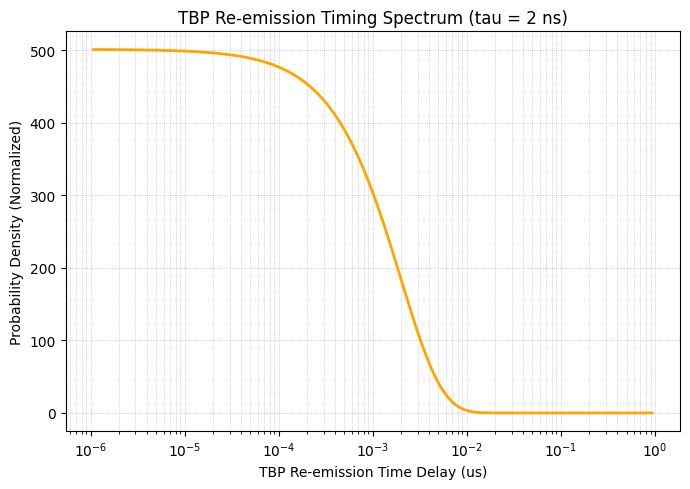

In [14]:
# Plotting the re-emission timing distribution we would like to sample from
# Define bins
bin_edges = np.geomspace(1e-6, 1, 100)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Compute scaled theoretical PDF
tau = 0.002 # re-emission lifetime of 2 nanoseconds
pdf_emission = (1 / tau) * np.exp(-bin_centers / tau)
pdf_integral = np.sum(pdf_emission * bin_widths)

norm_pdf = pdf_emission / pdf_integral
print('sum of normed pdf × bin widths:', np.sum(norm_pdf * bin_widths))

plt.figure(figsize=(7, 5))
plt.plot(bin_centers, norm_pdf, color='orange', lw=2)

plt.xscale('log')
plt.xlabel('TBP Re-emission Time Delay (us)')
plt.ylabel('Probability Density (Normalized)')
plt.title('TBP Re-emission Timing Spectrum (tau = 2 ns)')
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

Output shape: (128, 1000)


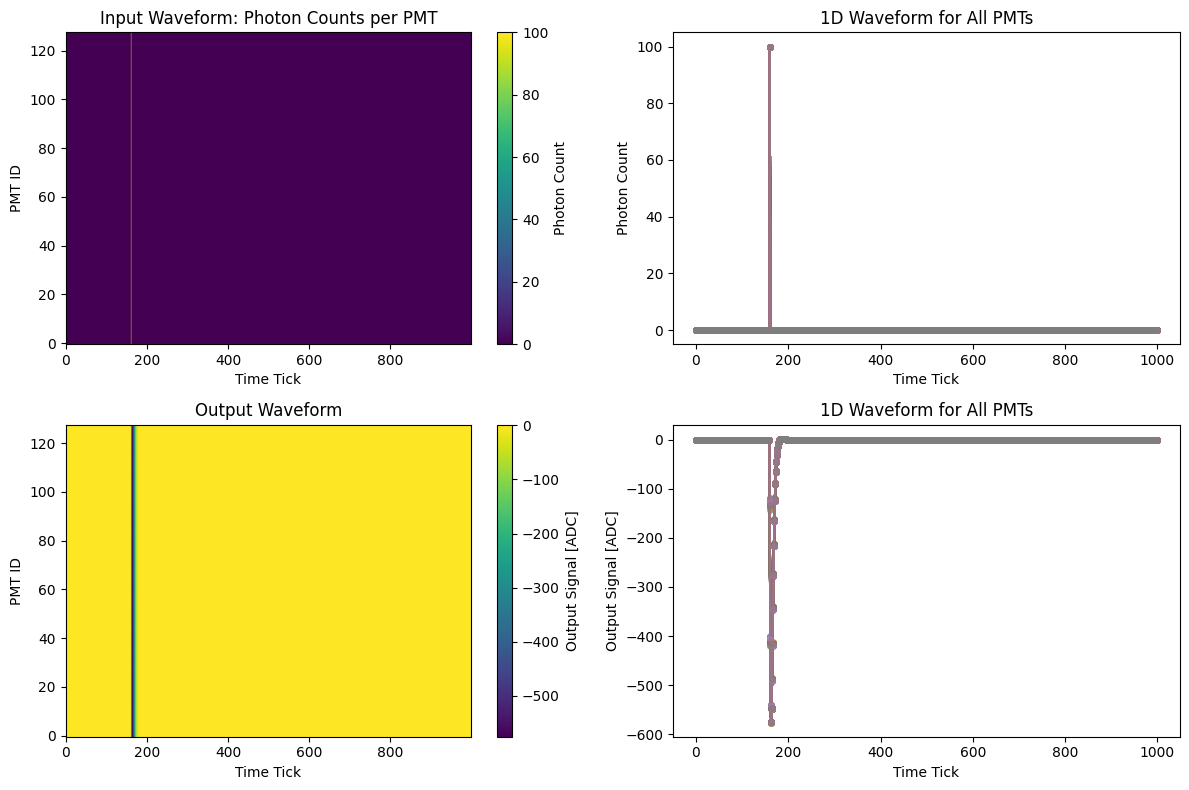

In [15]:
# Precise mode: 100 photons per pmt 
pmt_ids = torch.arange(128)
arrival_times = torch.zeros(128, dtype=torch.int64)
precise_wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, nphotons=100)
precise_wf_downsample = sim.downsample_waveform(precise_wf.unsqueeze(0))
precise_wf_downsample = precise_wf_downsample.squeeze(0)

wf = precise_wf_downsample

output, info, scint_delays = sim(precise_wf.to(device), tpb_delay=True)
output = output.detach().cpu().numpy()
print(f"Output shape: {output.shape}")

############### Plotting ############################

fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 row, 2 columns
ax1, ax2, ax3, ax4 = axs.flatten()

# Left plot: 2D waveform image  
im = ax1.imshow(wf, aspect='auto', origin='lower')
ax1.set_xlabel("Time Tick")
ax1.set_ylabel("PMT ID")
ax1.set_title("Input Waveform: Photon Counts per PMT")
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Photon Count")

# Right plot: 1D waveform lines
n_pmts, n_ticks = wf.shape
ticks = np.arange(n_ticks)
for i in range(n_pmts):
    ax2.plot(ticks, wf[i], marker='o', markersize=4, alpha=0.5)
ax2.set_xlabel("Time Tick")
ax2.set_ylabel("Photon Count")
ax2.set_title("1D Waveform for All PMTs")

# Bottm left: 2D timing histogram
im = ax3.imshow(output, aspect='auto', origin='lower')
ax3.set_xlabel("Time Tick")
ax3.set_ylabel("PMT ID")
ax3.set_title("Output Waveform")

cbar = fig.colorbar(im, ax=ax3)
cbar.set_label("Output Signal [ADC]")

# Bottom right: 1D line plot
ticks = np.arange(output.shape[1])
for i in range(n_pmts):
    ax4.plot(ticks, output[i], marker = 'o', markersize=4, alpha=0.5, label=i)
ax4.set_xlabel("Time Tick")
ax4.set_ylabel("Output Signal [ADC]")
ax4.set_title("1D Waveform for All PMTs")
plt.tight_layout()
plt.show()

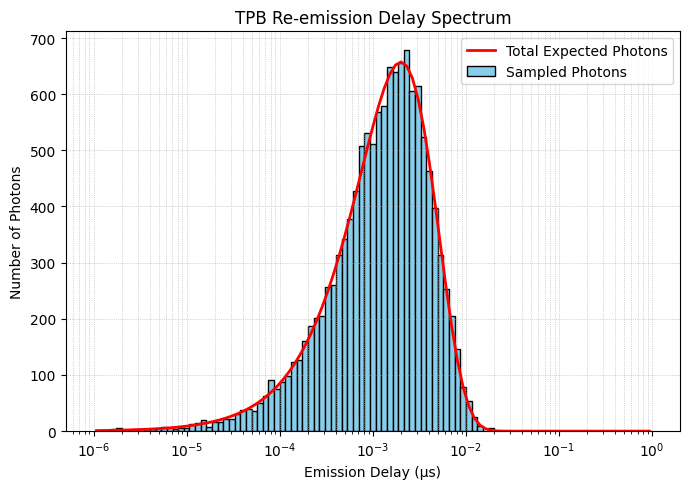

In [16]:
tpb_tau = 0.002  # 2 nanoseconds

# Define bins and compute bin centers/widths
bins = np.geomspace(1e-6, 1e0, 100)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_widths = bins[1:] - bins[:-1]

# Get all photon delays
emission_delays = info['tpb_emission_delays']
flat_delays = torch.cat(emission_delays).cpu().numpy()

# Compute histogram
hist, _ = np.histogram(flat_delays, bins=bins)

# Total photons that should be modeled
photons_arrived = info['num_singlets'] + info['num_triplets']

# Theoretical exponential PDF evaluated at bin centers
pdf = (1 / tpb_tau) * np.exp(-bin_centers / tpb_tau)

# Compute expected number of photons per bin by integrating (PDF × bin width)
expected = pdf * bin_widths
expected_scaled = expected / expected.sum() * photons_arrived

# Plot
plt.figure(figsize=(7, 5))
plt.bar(bin_centers, hist, width=bin_widths, color='skyblue', edgecolor='black', align='center', label='Sampled Photons')
plt.plot(bin_centers, expected_scaled, color='red', lw=2, label='Total Expected Photons')

plt.xscale('log')
plt.xlabel('Emission Delay (μs)')
plt.ylabel('Number of Photons')
plt.title('TPB Re-emission Delay Spectrum')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

1
12800


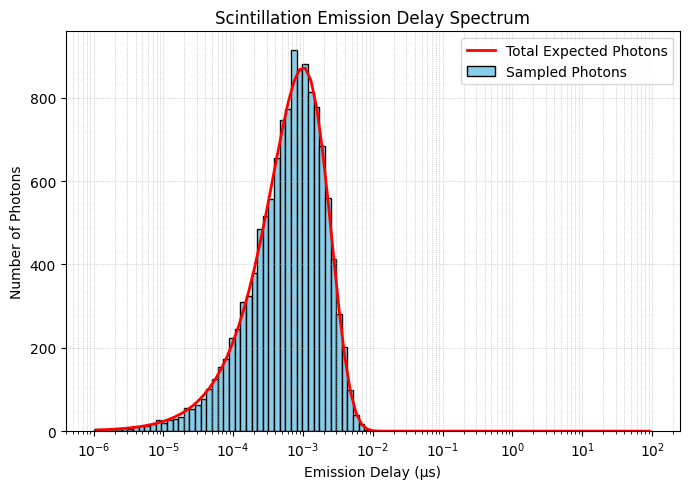

In [17]:
# Scintillation delay histogram
# Parameters from 'waveform_sim.yaml'
tau_s = sim.tau_s
tau_t = sim.tau_t
# singlet_frac = sim.cfg.NOMINAL_SINGLET_FRACTION
singlet_frac = sim.singlet_fraction
triplet_frac = 1 - singlet_frac
print(singlet_frac)

# Define bins
emission_delays = info['scintillation_delays']
flat_delays = torch.cat(emission_delays).cpu().numpy()  # shape: (N,)

bins = np.geomspace(1e-6, 1e2, 100)
hist, bin_edges = np.histogram(flat_delays, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_widths = bin_edges[1:] - bin_edges[:-1]

# calculating n_photons that reached pmt
photons_arrived = info['num_singlets'] + info['num_triplets']
print(photons_arrived)

# Compute scaled theoretical PDFs
pdf_s = (1 / tau_s) * np.exp(-bin_centers / tau_s)
pdf_t = (1 / tau_t) * np.exp(-bin_centers / tau_t)
pdf_s_scaled = pdf_s * singlet_frac * photons_arrived * bin_widths
pdf_t_scaled = pdf_t * triplet_frac * photons_arrived * bin_widths
total_scaled = pdf_s_scaled + pdf_t_scaled

# Plot
plt.figure(figsize=(7, 5))
plt.bar(bin_centers, hist, width=bin_widths, color='skyblue', edgecolor='black', align='center', label='Sampled Photons')
plt.plot(bin_centers, total_scaled, color='red', lw=2, label='Total Expected Photons')

plt.xscale('log')
plt.xlabel('Emission Delay (μs)')
plt.ylabel('Number of Photons')
plt.title('Scintillation Emission Delay Spectrum')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()